<a href="https://colab.research.google.com/github/Subhoshri/Spam-Detection/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"up14cp9225","key":"fb2dc9c6bc4010df97628a90a762f1f3"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown


In [7]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Load Dataset

In [45]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


We have a labeled dataset with 5 features for spam detection. A lot of data seems to be missing from the Unnamed feature columns.  

In [46]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [48]:
data.isnull().sum()

,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


Since there are several missing data, let's drop the three unnamed columns.

In [49]:
data=data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Data Visualization and Preprocessing

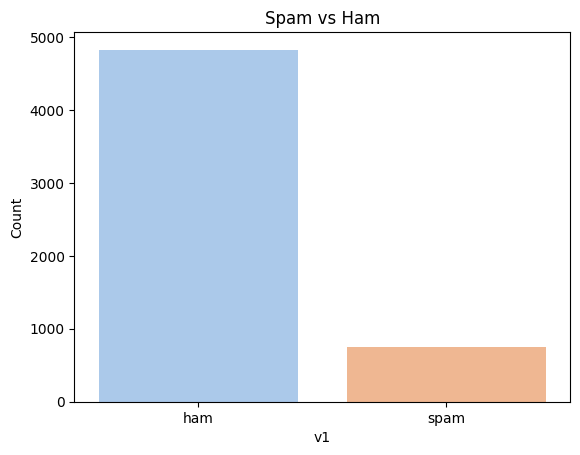

In [51]:
sns.barplot(x=data['v1'].value_counts().index,y=data['v1'].value_counts().values,palette='pastel',hue=data['v1'].value_counts().index)
plt.ylabel("Count")
plt.title("Spam vs Ham")
plt.show()

The dataset is imbalanced and might cause the model to predict ham more than spam, if not handled properly.

Now, to visualize the most common words using wordcloud. Also, stopwords and punctuations are removed to get a cleaner dataset.

[('u', 1119), ('call', 576), ('2', 478), ('im', 462), ('get', 386), ('ur', 384), ('4', 287), ('dont', 279), ('go', 278), ('ok', 277), ('ltgt', 276), ('free', 275), ('know', 257), ('like', 242), ('got', 238)]


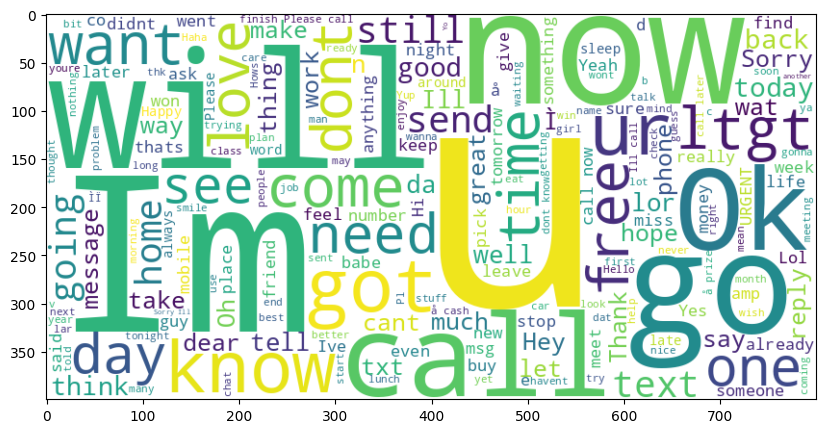

In [52]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
import nltk
import string

def remove_punctuation(text):
    translator=str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def most_frequent_words(text):
    text=text.lower().split()
    words=[]
    for i in text:
        if i not in stop_words:
            words.append(i)
    count=Counter(words)
    return count.most_common(15)

data['v2']=data['v2'].apply(remove_punctuation)
text = " ".join(data['v2'])
stop_words=set(stopwords.words('english'))

most_common=most_frequent_words(text)
print(most_common)

cloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.show()

Visualizing the most frequent words used in Spam messages. These include 'Free', 'now', 'text', 'call', 'win', 'prize' and other.

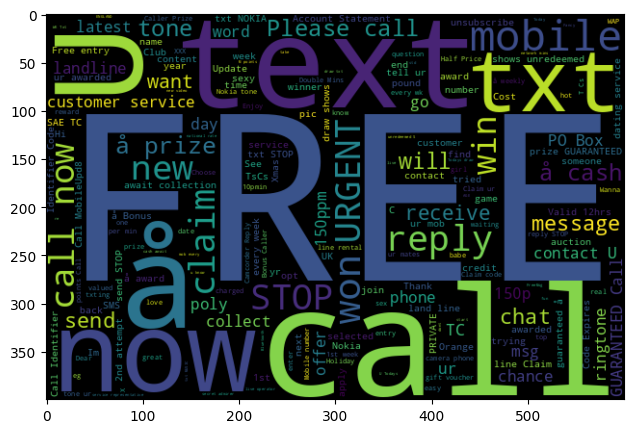

In [53]:
spam_words=' '.join(data[data['v1'] == 'spam']['v2'])
ham_words=' '.join(data[data['v1'] == 'ham']['v2'])

cloud=WordCloud(width=600, height=400).generate(spam_words).to_image()
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.show()

Spam messages often tend to be shorter or longer than unusual, so let's visualize that.

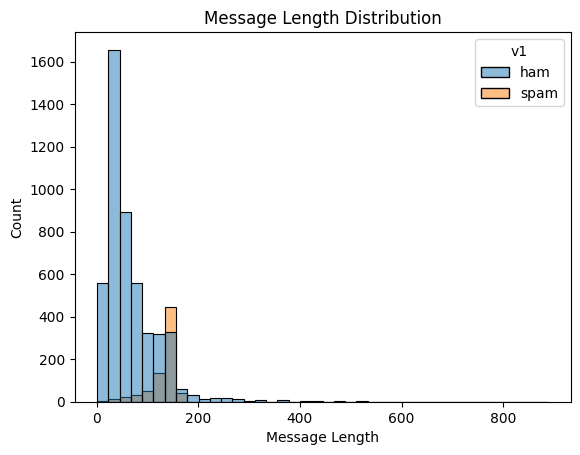

In [54]:
data['message_length'] = data['v2'].apply(len)

sns.histplot(data, x='message_length', hue='v1', bins=40)
plt.xlabel("Message Length")
plt.title("Message Length Distribution")
plt.show()

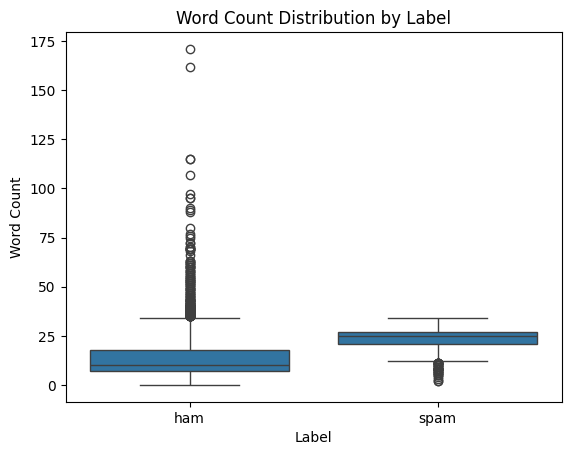

In [55]:
data['word_count'] = data['v2'].apply(lambda x: len(x.split()))
sns.boxplot(x='v1', y='word_count', data=data)
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.title("Word Count Distribution by Label")
plt.show()

Spam words tend to be centred around 20-30 words making them uniform in length while ham messages vary depending upon the user sending.

In [56]:
data['v1'].value_counts(normalize=True)

,proportion
v1,
ham,0.865937
spam,0.134063


In [57]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
data['message']=data['v2'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Text Vectorization
Let's use TF-IDF to vectorize text and highlight words that occur frequently like 'win', 'prize' but not too common across all texts. This will help in weighing words that are more likely to occur in spam messages.

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

x=data['v2']
y=data['v1']

encode=LabelEncoder()
y=encode.fit_transform(y)

tfidf=TfidfVectorizer(stop_words='english', max_df=0.95, ngram_range=(1,2),min_df=5)
x=tfidf.fit_transform(x)
joblib.dump(tfidf, 'vectorizer.pkl')

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=42)

# Model Building

First, let's predict using Logistic Regression, followed by MultinomialNB and SVM.

In [79]:
from sklearn.linear_model import LogisticRegression

model1=LogisticRegression(class_weight='balanced', max_iter=1000)
model1.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [81]:
print("Train:", np.bincount(y_train))
print("Test:", np.bincount(y_test))

Train: [3860  597]
Test: [965 150]


In [87]:
from sklearn.naive_bayes import MultinomialNB
model2=MultinomialNB()
model2.fit(x_train, y_train)

MultinomialNB()

In [89]:
from sklearn.svm import LinearSVC
model3=LinearSVC(class_weight='balanced')
model3.fit(x_train, y_train)

LinearSVC(class_weight='balanced')

In [91]:
from sklearn.ensemble import RandomForestClassifier
model4=RandomForestClassifier(class_weight='balanced', n_estimators=200)
model4.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200)

# Evaluation Metrics

In [82]:
y_pred1=model1.predict(x_test)
print("Accuracy: ",accuracy_score(y_test,y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy:  0.9757847533632287
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.93      0.89      0.91       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [88]:
y_pred2=model2.predict(x_test)
print("Accuracy: ",accuracy_score(y_test,y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy:  0.9730941704035875
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [90]:
y_pred3=model3.predict(x_test)
print("Accuracy: ",accuracy_score(y_test,y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy:  0.97847533632287
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [92]:
y_pred4=model4.predict(x_test)
print("Accuracy: ",accuracy_score(y_test,y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy:  0.9757847533632287
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.84      0.90       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.98      1115



Linear SVM gives the best accuracy and evaluation scores as base model. Let's hypertune further to improve model performance.

# Hypertuning Parameters

In [99]:
from sklearn.model_selection import GridSearchCV

#Logistic Regression
param_grid={'C': [0.01, 0.1, 1, 10],'solver': ['liblinear', 'lbfgs']}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000),param_grid, scoring='accuracy', cv=5)
grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
model1=grid.best_estimator_

Best params: {'C': 10, 'solver': 'lbfgs'}


In [100]:
# Linear SVM
param_grid_svm={'C': [0.01, 0.1, 1, 10],'loss': ['hinge', 'squared_hinge']}

grid_svm=GridSearchCV(LinearSVC(class_weight='balanced', max_iter=1000),param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(x_train, y_train)

print("Best LinearSVC Params:", grid_svm.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best LinearSVC Params: {'C': 0.1, 'loss': 'squared_hinge'}


In [101]:
# Multinomial NB
param_grid_nb={'alpha': [0.01, 0.1, 1, 5, 10],'fit_prior': [True, False]}

grid_nb = GridSearchCV(MultinomialNB(),param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(x_train, y_train)

print("Best MultinomialNB Params:", grid_nb.best_params_)

Best MultinomialNB Params: {'alpha': 0.1, 'fit_prior': True}


In [102]:
print("Best Logistic Regression score:", grid.best_score_)
print("Best LinearSVC Score:", grid_svm.best_score_)
print("Best MultinomialNB Score:", grid_nb.best_score_)

Best Logistic Regression score: 0.9809288701665384
Best LinearSVC Score: 0.9798065357108706
Best MultinomialNB Score: 0.9795813138862466


Logistic Regression model performs the best, so we'll save this as our final model with an accuracy of 98.09%.

# Saving Model

In [103]:
import joblib
joblib.dump(model1, 'spam_detection_model.pkl')

['spam_detection_model.pkl']

# Predicting Spam or Ham

In [108]:
import re

model=joblib.load('spam_detection_model.pkl')
vectorizer=joblib.load('vectorizer.pkl')

def preprocess_text(text):
    text=text.lower()
    text=re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

def predict_spam_or_ham(text):
    text=preprocess_text(text)
    text_tfidf = vectorizer.transform([text])

    prediction = model.predict(text_tfidf)

    return 'Spam' if prediction == 1 else 'Ham'

In [109]:
input_text="Congratulations! You've won a lottery. Click here to claim your prize."
prediction=predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Spam


In [110]:
input_text = "Claim your free prize now! Visit our website and get a free iPhone."
prediction = predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Spam


In [111]:
input_text = "Hey, do you want to catch up later this week?"
prediction = predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Ham


In [112]:
input_text = "You have been selected for a free vacation, respond immediately to claim."
prediction = predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Spam


In [113]:
input_text = "Can you please send me the report for last week's meeting?"
prediction = predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Ham


In [114]:
input_text = "URGENT: Your account has been compromised. Click here to reset your password."
prediction = predict_spam_or_ham(input_text)
print(f"Prediction: {prediction}")

Prediction: Spam


Our model works quite well with an accuracy of 98.09% and successfully classifies messages as spam or ham.